# VCOMP Assignment 2


# Proposal 5: CAPTCHA Decoding

## Motivation
A CAPTCHA (Completely Automated Public Touring test to Tell Computers and Humans Apart) is a commonly used feature in web applications to block non-human access. CAPTCHAs’ purpose is to prevent spam on websites, such as promotion spam, registration spam, and data scraping. Bots are less likely to abuse websites with spamming if those websites use CAPTCHA. Many websites use CAPTCHA to prevent bot raiding, and it works effectively. CAPTCHA’s design is such that humans can complete CAPTCHAs, while most robots cannot.

## Dataset
- **Dataset Size**: 14,860 images.  
- **Format**: Two datasets divided into train and test, with the label in the image name (contains 4 or 5 characters):  
  - **Soft dataset**: Formed by CAPTCHAs that are simpler. Students must start the project with this dataset.  
  - **Hard dataset**: Formed by CAPTCHAs with strange elements added to make the identification more difficult to predict.  

**[Download Link](https://uporto-my.sharepoint.com/:f:/g/personal/up488707_up_pt/EnnrytvkVKlPuQ9qDoS7tpQBuRJ_Pecv_zWi_-9LSxC2lw?e=4GHGLo)**

## Challenge
1. Propose a custom AI model that decodes CAPTCHA images considering 4 and 5 encoders. The model of the CNN needs to be designed, implemented, and trained (no fine-tuning approaches should be applied).
2. Use the following metrics to assess the quality of your implementation:
   - Train and test accuracy.
   - Confusion matrix.
   - Other evaluation methodologies (e.g., histograms, model complexity).
3. Discuss the result of your approach, particularly limitations.


We moved the dataset to Google Drive as a .rar file, so we will download it and extract its content.

In [ ]:
!pip install gdown -q
!pip install rarfile -q

In [ ]:
import gdown
import rarfile
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from collections import Counter
import re
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torch.optim as optim
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm import tqdm
import time
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


In [ ]:
gdrive_link = "https://drive.google.com/file/d/10pZfMgf9hBOPu8E3JpcjZtRmeG9ZKymh/view?usp=sharing"
output_filename = "dataset.rar"

file_id = gdrive_link.split('/d/')[1].split('/')[0]
direct_link = f"https://drive.google.com/uc?id={file_id}"
gdown.download(direct_link, output_filename, quiet=True)

with rarfile.RarFile(output_filename) as rf:
    rf.extractall(path=".")

We managed the length variance by considering all the CAPTCHAs composed by 5 component and we used the character @ to represent the blank space


In [ ]:
alphabet = '0123456789abcdefghijklmnopqrstuvwxyz@'
max_length = 5
alphabet_length = len(alphabet)

##Dataset Structure

Here we compute and plot the character frequencies in order to study how (un)balanced the datasets are

SOFT Train


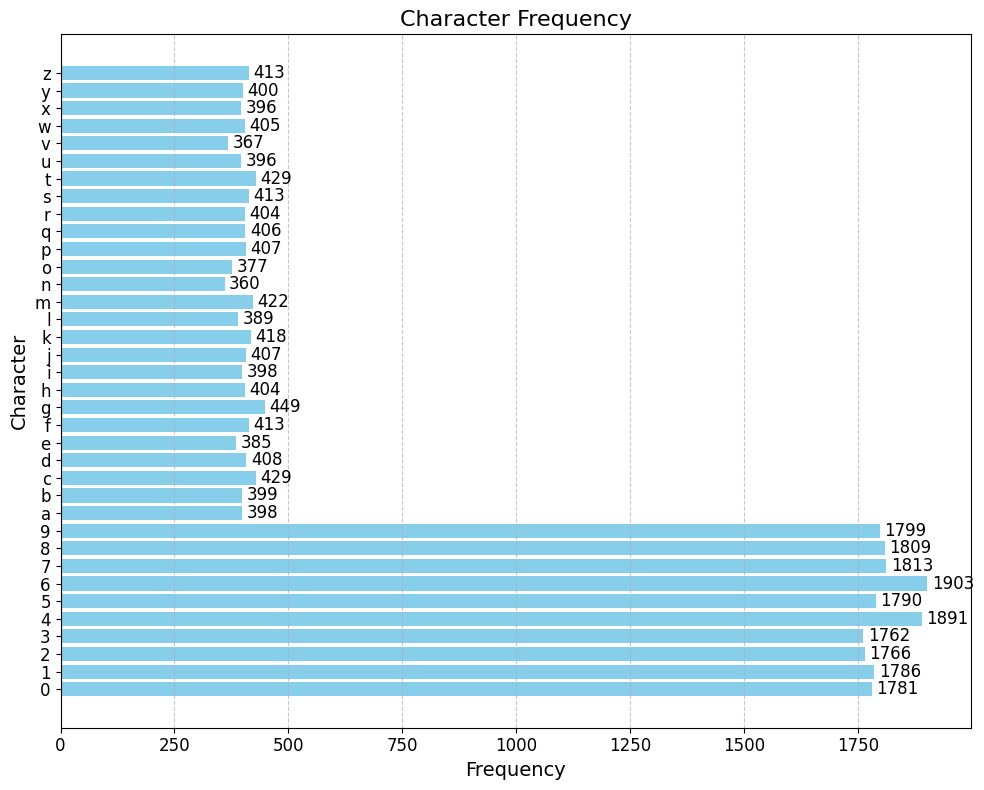

HARD Train


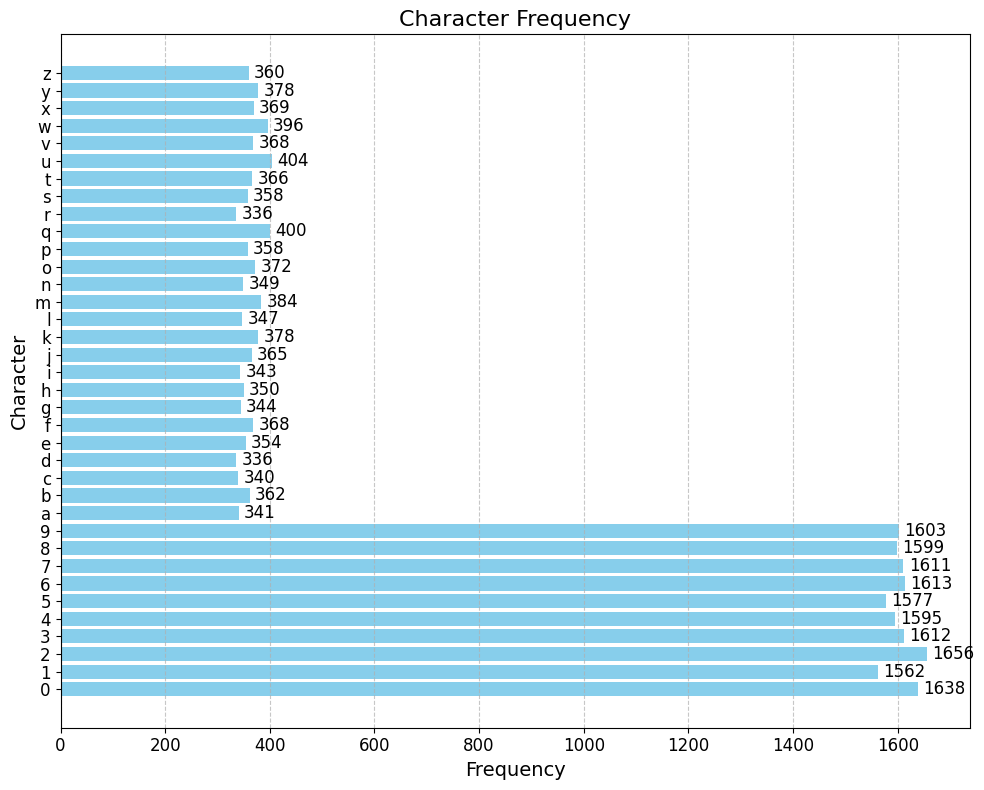

In [ ]:
def compute_char_frequencies(folder_path):

    char_counter = Counter()

    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            base_name = os.path.splitext(filename)[0]
            char_counter.update(base_name)

    return char_counter

def plot_frequencies(frequencies):

    sorted_items = sorted(frequencies.items())
    characters, counts = zip(*sorted_items)

    plt.figure(figsize=(10, 8))
    bar_width = 0.8
    bars = plt.barh(characters, counts, color='skyblue', height=bar_width)


    for bar, count in zip(bars, counts):
        plt.text(
            bar.get_width() + 10,
            bar.get_y() + bar.get_height() / 2,
            str(count),
            ha='left', va='center', fontsize=12, color='black'
        )

    plt.ylabel('Character', fontsize=14)
    plt.xlabel('Frequency', fontsize=14)
    plt.title('Character Frequency', fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


soft_path = "/content/CAPTCHA_dataset/soft/train"
hard_path = "/content/CAPTCHA_dataset/hard/train"
soft_frequencies = compute_char_frequencies(soft_path)
print('SOFT Train')
plot_frequencies(soft_frequencies)
hard_frequencies = compute_char_frequencies(hard_path)
print('HARD Train')
plot_frequencies(hard_frequencies)




In [ ]:
def encode_label(label):

    target = np.zeros((max_length, alphabet_length))

    for j, char in enumerate(label):
        index = alphabet.find(char)
        target[j, index] = 1

    if len(label) == 4:
        target[4, alphabet_length - 1] = 1

    return target.flatten()


def load_image_paths_and_labels(directory):
    image_paths = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            image_path = os.path.join(directory, filename)
            image_paths.append(image_path)
            label = re.sub(r'\.\w+$', '', filename)
            labels.append(label)

    return image_paths, labels

The dataset structure is composed by image paths and label encoded with one hot vectors, it gives the possibility to apply augmentation in different cases, since the dataset is unblanced and there are many more numbers compared to letters in our train images, we augmented the images with at least 4 letters inside, for the same unbalancing problem we had really bad performance on the o and l letters that were often predicted as 0 or 1, we introduced some augmentation that was rotating images containing zeros, and some augmentation that was zooming more or less and traslating casually the images containing o and/or l

In [ ]:
class CaptchaDataset(Dataset):
    def __init__(
        self,
        file_paths,
        train_transform=None,
        test_transform=None,
        augment_0_transform=None,
        augment_4_letters_transform=None,
        augment_o_l_transform=None,
        augment_0_ratio=0,
        augment_4_letters_ratio=0,
        augment_o_l_ratio=0,
    ):
        """
        Initialize the CaptchaDataset.

        Parameters:
            file_paths: List of file paths to images.
            train_transform: Transforms applied to all training images.
            test_transform: Transforms applied to test images.
            augment_0_transform: Additional transforms for images with label containing '0'.
            augment_4_letters_transform: Transforms for images containing at least 4 letters.
            augment_o_l_transform: Transforms for images containing 'o' or 'l'.
            augment_0_ratio: Number of augmented duplicates for '0'-containing images.
            augment_4_letters_ratio: Number of augmented duplicates for images with 4+ letters.
            augment_o_l_ratio: Number of augmented duplicates for images with 'o' or 'l'.
            augment_0: Whether to augment images containing '0'.
            augment_4_letters: Whether to augment images containing at least 4 letters.
            augment_o_l: Whether to augment images containing 'o' or 'l'.
        """
        self.file_paths = file_paths
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.augment_0_transform = augment_0_transform
        self.augment_4_letters_transform = augment_4_letters_transform
        self.augment_o_l_transform = augment_o_l_transform
        self.augment_0_ratio = augment_0_ratio
        self.augment_4_letters_ratio = augment_4_letters_ratio
        self.augment_o_l_ratio = augment_o_l_ratio

        self.file_paths_with_augmentation = []
        for img_path in self.file_paths:
            label = os.path.splitext(os.path.basename(img_path))[0]
            self.file_paths_with_augmentation.append((img_path, "original"))  # Original image

            if self.augment_0_ratio>0 and '0' in label:
                for _ in range(self.augment_0_ratio):
                    self.file_paths_with_augmentation.append((img_path, "augment_0"))

            if self.augment_4_letters_ratio>0 and self.contains_at_least_four_letters(label):
                for _ in range(self.augment_4_letters_ratio):
                    self.file_paths_with_augmentation.append((img_path, "augment_4_letters"))

            if self.augment_o_l_ratio>0 and ('o' in label or 'l' in label):
                for _ in range(self.augment_o_l_ratio):
                    self.file_paths_with_augmentation.append((img_path, "augment_o_l"))

    def __len__(self):
        return len(self.file_paths_with_augmentation)

    def __getitem__(self, idx):
        img_path, augment_type = self.file_paths_with_augmentation[idx]
        label = os.path.splitext(os.path.basename(img_path))[0]

        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        img = Image.fromarray(img)

        if augment_type == "original" and self.train_transform:
            img = self.train_transform(img)
        elif augment_type == "augment_0" and self.augment_0_transform:
            img = self.augment_0_transform(img)
        elif augment_type == "augment_4_letters" and self.augment_4_letters_transform:
            img = self.augment_4_letters_transform(img)
        elif augment_type == "augment_o_l" and self.augment_o_l_transform:
            img = self.augment_o_l_transform(img)

        if self.test_transform:
            img = self.test_transform(img)
        encoded_label = encode_label(label)
        encoded_label = torch.from_numpy(encoded_label)

        return img, label, encoded_label

    @staticmethod
    def contains_at_least_four_letters(label):
        """
        Check if the CAPTCHA contains at least 4 letters.
        """
        letters = set("abcdefghijklmnopqrstuvwxyz")
        count_letters = sum(1 for char in label if char in letters)
        return count_letters >= 4


def safe_to_tensor(img):
    if isinstance(img, torch.Tensor):
        return img
    return transforms.ToTensor()(img)

# Define transforms
test_transform = transforms.Compose([
    safe_to_tensor,
])

train_transform = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
    safe_to_tensor,
])

augment_0_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    safe_to_tensor,
])

augment_4_letters_transform = transforms.Compose([
    transforms.RandomAffine(degrees=15, shear=5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    safe_to_tensor,
])

augment_o_l_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), translate=(0.2, 0.2)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    safe_to_tensor,
])


##Model definition and structure


For this task we decided to implement a ResNet inspired model in order to take advantage of the residual connections avoiding the vanishing gradient problem in a deeper network.

The 3 convolutional layers work  

1.   Reducing the number of channels
2.   Extracting spacial feature
3.   Restoring the number of output channels

Each convolution is followed by a Batch Normalization layer to stabilize training

The ReLU activation function enables the model to function in non-linearity stuation.


The Shortcut Connections allow the gradient to flow directly to early layers during back propagatioon and helps passing the input to the last layers in the forward pass




In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, expansion=4):
        super().__init__()

        hidden_dim = out_channels // expansion

        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(hidden_dim)

        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(hidden_dim)

        self.conv3 = nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(identity)
        out = self.relu(out)

        return out

The network begins with a 7x7 convolutional layer to extract large-scale features from the CAPTCHA images. This is crucial for recognizing distorted characters and patterns. Batch normalization stabilizes the training process, and max pooling downsamples the feature maps, reducing computational cost while preserving essential information.

Then we use multiple residual layers allow the network to learn hierarchical features, capturing both low-level edges and high-level patterns

The Adaptive Averafe Pooling reduces the spatial dimensions to a fixed size of `1x1`, regardless of the input size, ensuring compatibility with fully connected layers.

We also included Dropout with a 30% rate to reduce overfitting


In [ ]:
class CAPTCHA_CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.3):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [
            ResidualBlock(in_channels, out_channels, stride)
        ]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

##Functions for training and evaluation

Here we have all the functions that we are usign for training and evaluation of the dataset such as the main training lood or the generations of predictions and confusion matrix

In [ ]:
def extract_character(start_index, end_index,prediction):
        segment = prediction.squeeze().cpu().tolist()[start_index:end_index]
        return alphabet[np.argmax(segment)]
def get_label(prediction):
    characters = [
        extract_character(alphabet_length * i, alphabet_length * (i + 1),prediction)
        for i in range(5)
    ]

    if characters[4] == "@":
        return ''.join(characters[:4])
    else:
        return ''.join(characters)

def get_batch_accuracy(predictions, labels):
    correct_predictions = sum(
        label == get_label(prediction)
        for prediction, label in zip(predictions, labels)
    )
    return correct_predictions

This part consists of three main functions: train, evaluate, and train_evaluate. Each function contributes to a specific stage of the model's lifecycle.

In the train loop Batch-wise accuracy and loss are accumulated. The accuracy is computed using a helper function get_batch_accuracy (assumed to compare predictions to ground truth)

Evaluate function evaluates the model on a validation dataset

train_evaluate function integrates training and validation over multiple epochs, manages learning rate scheduling, saves the best model, and implements early stopping.

In [ ]:
from tqdm import tqdm
import numpy as np

from torch.autograd import Variable

def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs):
  model.train()
  count = 0
  train_loss = 0
  for step, (img, label, label_oh) in enumerate(dataloader):
    img = img.to(device)
    label_oh = label_oh.float().to(device)
    optimizer.zero_grad()
    pred = model(img)
    count += get_batch_accuracy(pred, label)
    loss = loss_fn(pred, label_oh)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  acc = count/(len(dataloader) * 64)

  return acc, train_loss/len(dataloader)

def evaluate(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            device: torch.device):
  val_loss = 0
  count = 0
  model.eval()
  for step, (img, label, encoded_label) in enumerate(dataloader):
    img = Variable(img).to(device)
    encoded_label = Variable(encoded_label.float()).to(device)
    pred = model(img)
    loss = loss_fn(pred, encoded_label)
    val_loss += loss.item()

    label_pred = get_label(pred)

    if(label[0] == label_pred):
      count+= 1

  acc = count/len(dataloader)

  return acc, val_loss/len(dataloader)



def train_evaluate(model, dataloader_train, dataloader_val, loss_fn, optimizer, device, epochs, name_file, scheduler=None, early_stop_patience=10):
    hist_train = []
    hist_val = []

    best_val_acc = np.NINF
    early_stop_counter = 0

    try:
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            acc_train, train_loss = train(model, dataloader_train, loss_fn, optimizer, device,epochs)
            acc_val, val_loss = evaluate(model, dataloader_val, loss_fn, device)

            if acc_val > best_val_acc:
                best_val_acc = acc_val
                early_stop_counter = 0
                torch.save(model.state_dict(), name_file)
                print(f"Model saved with validation accuracy: {best_val_acc:.4f}")
            else:
                early_stop_counter += 1

            if scheduler:
                scheduler.step(val_loss)
            hist_train.append((epoch + 1, train_loss, acc_train))
            hist_val.append((epoch + 1, val_loss, acc_val))

            print(f"Train Loss: {train_loss:.4f}, Train Acc: {acc_train:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {acc_val:.4f}, Best Val Acc: {best_val_acc:.4f}")

            if early_stop_counter >= early_stop_patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

    except KeyboardInterrupt:
        print("\nTraining interrupted. Saving current progress...")
        torch.save(model.state_dict(), name_file)

    return hist_train, hist_val


## Helper functions to retrive metrics and display them

In [ ]:
def plot_training_metrics(hist_train, hist_val):
    def extract_metric(history, metric_index):
        return [item[metric_index] for item in history]

    def create_plot(x_data, y1_data, y2_data, y1_label, y2_label, y_label):
        plt.figure(figsize=(10, 5))
        plt.plot(x_data, y1_data, label=y1_label)
        plt.plot(x_data, y2_data, label=y2_label)
        plt.xlabel('Epoch')
        plt.ylabel(y_label)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    epochs = extract_metric(hist_train, 0)

    train_losses = extract_metric(hist_train, 1)
    train_acc = extract_metric(hist_train, 2)

    val_losses = extract_metric(hist_val, 1)
    val_acc = extract_metric(hist_val, 2)

    create_plot(epochs, train_losses, val_losses, 'Train Loss', 'Val Loss', 'Loss')
    create_plot(epochs, train_acc, val_acc, 'Train Acc', 'Val Acc', 'Accuracy')

In [ ]:
def process_predictions(predictions):
    processed = predictions.copy()
    for prediction_set in processed:
        for i in range(max_length):
            idx = np.argmax(prediction_set[i, 0:alphabet_length])
            prediction_set[i, 0:alphabet_length].fill(0)
            prediction_set[i, idx] = 1

    return processed

def get_predictions(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    device: torch.device):
    model.eval()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for img, label, encoded_label in dataloader:
            img = img.to(device)
            encoded_label = encoded_label.float().to(device)
            predictions = model(img)
            encoded_label = encoded_label.cpu().numpy().reshape(-1, max_length, alphabet_length)
            predictions = predictions.cpu().numpy().reshape(-1, max_length, alphabet_length)
            processed_predictions = process_predictions(predictions)
            true_labels.append(encoded_label)
            predicted_labels.append(processed_predictions)

    return np.array(true_labels), np.array(predicted_labels)



In [ ]:
def generate_confusion_matrix(true_labels, predicted_labels):
    def compute_cumulative_confusion_matrix(true_labels, predicted_labels):
        cumulative_matrix = np.zeros(
            (alphabet_length, alphabet_length),
            dtype=np.int32
        )
        true_labels_flattened = true_labels.reshape(-1, alphabet_length)
        predicted_labels_flattened = predicted_labels.reshape(-1, alphabet_length)
        true_indices = np.argmax(true_labels_flattened, axis=1)
        pred_indices = np.argmax(predicted_labels_flattened, axis=1)
        cumulative_matrix = confusion_matrix(
            true_indices,
            pred_indices,
            labels=range(alphabet_length)
        )

        return cumulative_matrix

    def visualize_confusion_matrix(confusion_matrix):

        plt.figure(figsize=(15, 15))

        confusion_display = ConfusionMatrixDisplay(
            confusion_matrix=confusion_matrix,
            display_labels=alphabet
        )

        confusion_display.plot(
            cmap='Blues',
            values_format='d',
            ax=plt.gca()
        )

        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()

        return confusion_matrix
    cumulative_matrix = compute_cumulative_confusion_matrix(
        true_labels,
        predicted_labels
    )

    return visualize_confusion_matrix(cumulative_matrix)

In [ ]:
def get_metrics(confusion_matrix):
    true_positives = np.diag(confusion_matrix)
    total_predicted_positive = np.sum(confusion_matrix, axis=0)
    total_actual_positive = np.sum(confusion_matrix, axis=1)
    total_samples = np.sum(confusion_matrix)
    def safe_divide(numerator, denominator):
        return np.divide(
            numerator,
            denominator,
            out=np.zeros_like(numerator, dtype=float),
            where=denominator != 0
        )

    precision = safe_divide(
        true_positives,
        total_predicted_positive
    )

    recall = safe_divide(
        true_positives,
        total_actual_positive
    )

    f1_score = safe_divide(
        2 * precision * recall,
        precision + recall
    )

    accuracy = np.sum(true_positives) / total_samples

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'accuracy': accuracy
    }

##Soft Dataset Setup

We created our data loaders diving the train set in train and validation with a 95/5 ratio, we also created a data loader with all the implemented augmentations included


In [ ]:
soft_train_dir = "./CAPTCHA_dataset/soft/train"
soft_test_dir = "./CAPTCHA_dataset/soft/test"

soft_train_image_paths, soft_train_labels = load_image_paths_and_labels(soft_train_dir)
soft_test_image_paths, soft_test_labels = load_image_paths_and_labels(soft_test_dir)

train_size = int(0.95 * len(soft_train_image_paths))
val_size = len(soft_train_image_paths) - train_size

indices = torch.randperm(len(soft_train_image_paths)).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

soft_train_image_paths_split = [soft_train_image_paths[i] for i in train_indices]
soft_val_image_paths_split = [soft_train_image_paths[i] for i in val_indices]

soft_train_labels_split = [soft_train_labels[i] for i in train_indices]
soft_val_labels_split = [soft_train_labels[i] for i in val_indices]


soft_train_dataset_split = CaptchaDataset(
    soft_train_image_paths_split,
    train_transform=train_transform
)

soft_val_dataset_split = CaptchaDataset(
    soft_val_image_paths_split,
    train_transform=test_transform
)


soft_train_dataset_augmented_o_four_l = CaptchaDataset(
    file_paths=soft_train_image_paths_split,
    train_transform=train_transform,
    test_transform=test_transform,
    augment_0_transform=augment_0_transform,
    augment_4_letters_transform=augment_4_letters_transform,
    augment_o_l_transform=augment_o_l_transform,
    augment_0_ratio=2,
    augment_4_letters_ratio=3,
    augment_o_l_ratio=2,
)

soft_test_dataset = CaptchaDataset(
    soft_test_image_paths,
    test_transform=test_transform
)

soft_train_loader = DataLoader(soft_train_dataset_split, batch_size=64, shuffle=True)
soft_train_loader_augmented = DataLoader(soft_train_dataset_augmented_o_four_l, batch_size=64, shuffle=True)
soft_val_loader = DataLoader(soft_val_dataset_split, batch_size=1, shuffle= True)
soft_test_loader = DataLoader(soft_test_dataset, batch_size=1, shuffle=False)


## Soft Normal Training



We decided to use the `nn.MultiLabelSoftMarginLoss()` because recognizing the sequences of characters means we are predicting multiple outputs at the same time

We are using a scheduler to reduce the learning rate when validation loss stops improving this allows finer adjustments and helps to avoid stagnation

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CAPTCHA_CNN(max_length * alphabet_length).to(device)
loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

hist_train, hist_val = train_evaluate(
    model=model,
    dataloader_train=soft_train_loader,
    dataloader_val=soft_val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=100,
    name_file="best_model_soft.pth",
    scheduler=scheduler,
    early_stop_patience=25
)


Epoch 1/100
Model saved with validation accuracy: 0.0000
Train Loss: 0.1457, Train Acc: 0.0000
Val Loss: 0.1124, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 2/100
Train Loss: 0.1114, Train Acc: 0.0000
Val Loss: 0.1095, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 3/100
Train Loss: 0.1087, Train Acc: 0.0000
Val Loss: 0.1211, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 4/100
Train Loss: 0.1047, Train Acc: 0.0002
Val Loss: 0.1347, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 5/100
Train Loss: 0.0984, Train Acc: 0.0008
Val Loss: 0.0998, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 6/100
Model saved with validation accuracy: 0.0031
Train Loss: 0.0928, Train Acc: 0.0018
Val Loss: 0.0901, Val Acc: 0.0031, Best Val Acc: 0.0031

Epoch 7/100
Train Loss: 0.0860, Train Acc: 0.0053
Val Loss: 0.0853, Val Acc: 0.0031, Best Val Acc: 0.0031

Epoch 8/100
Train Loss: 0.0796, Train Acc: 0.0141
Val Loss: 0.1189, Val Acc: 0.0031, Best Val Acc: 0.0031

Epoch 9/100
Model saved with validation accuracy: 0.0

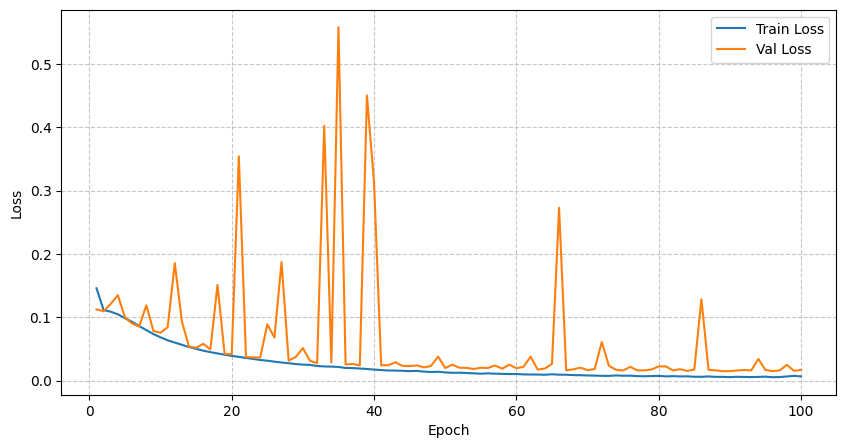

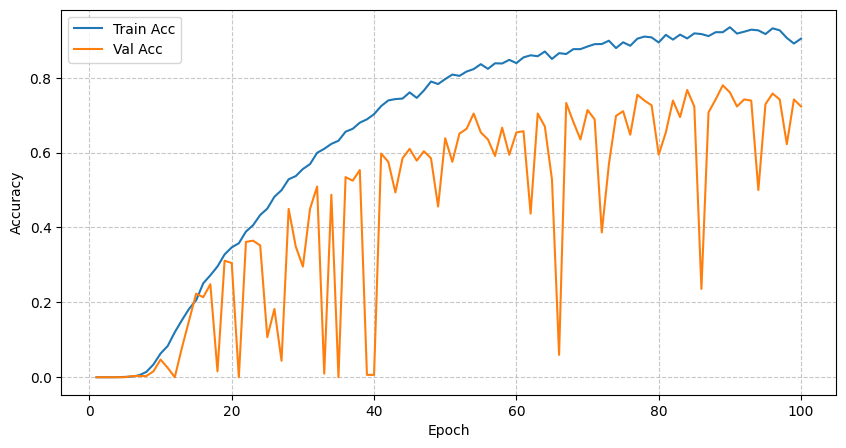

In [ ]:
plot_training_metrics(hist_train, hist_val)

##Soft evaluation

<ipython-input-19-f73820c467ea>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_soft.pth"))


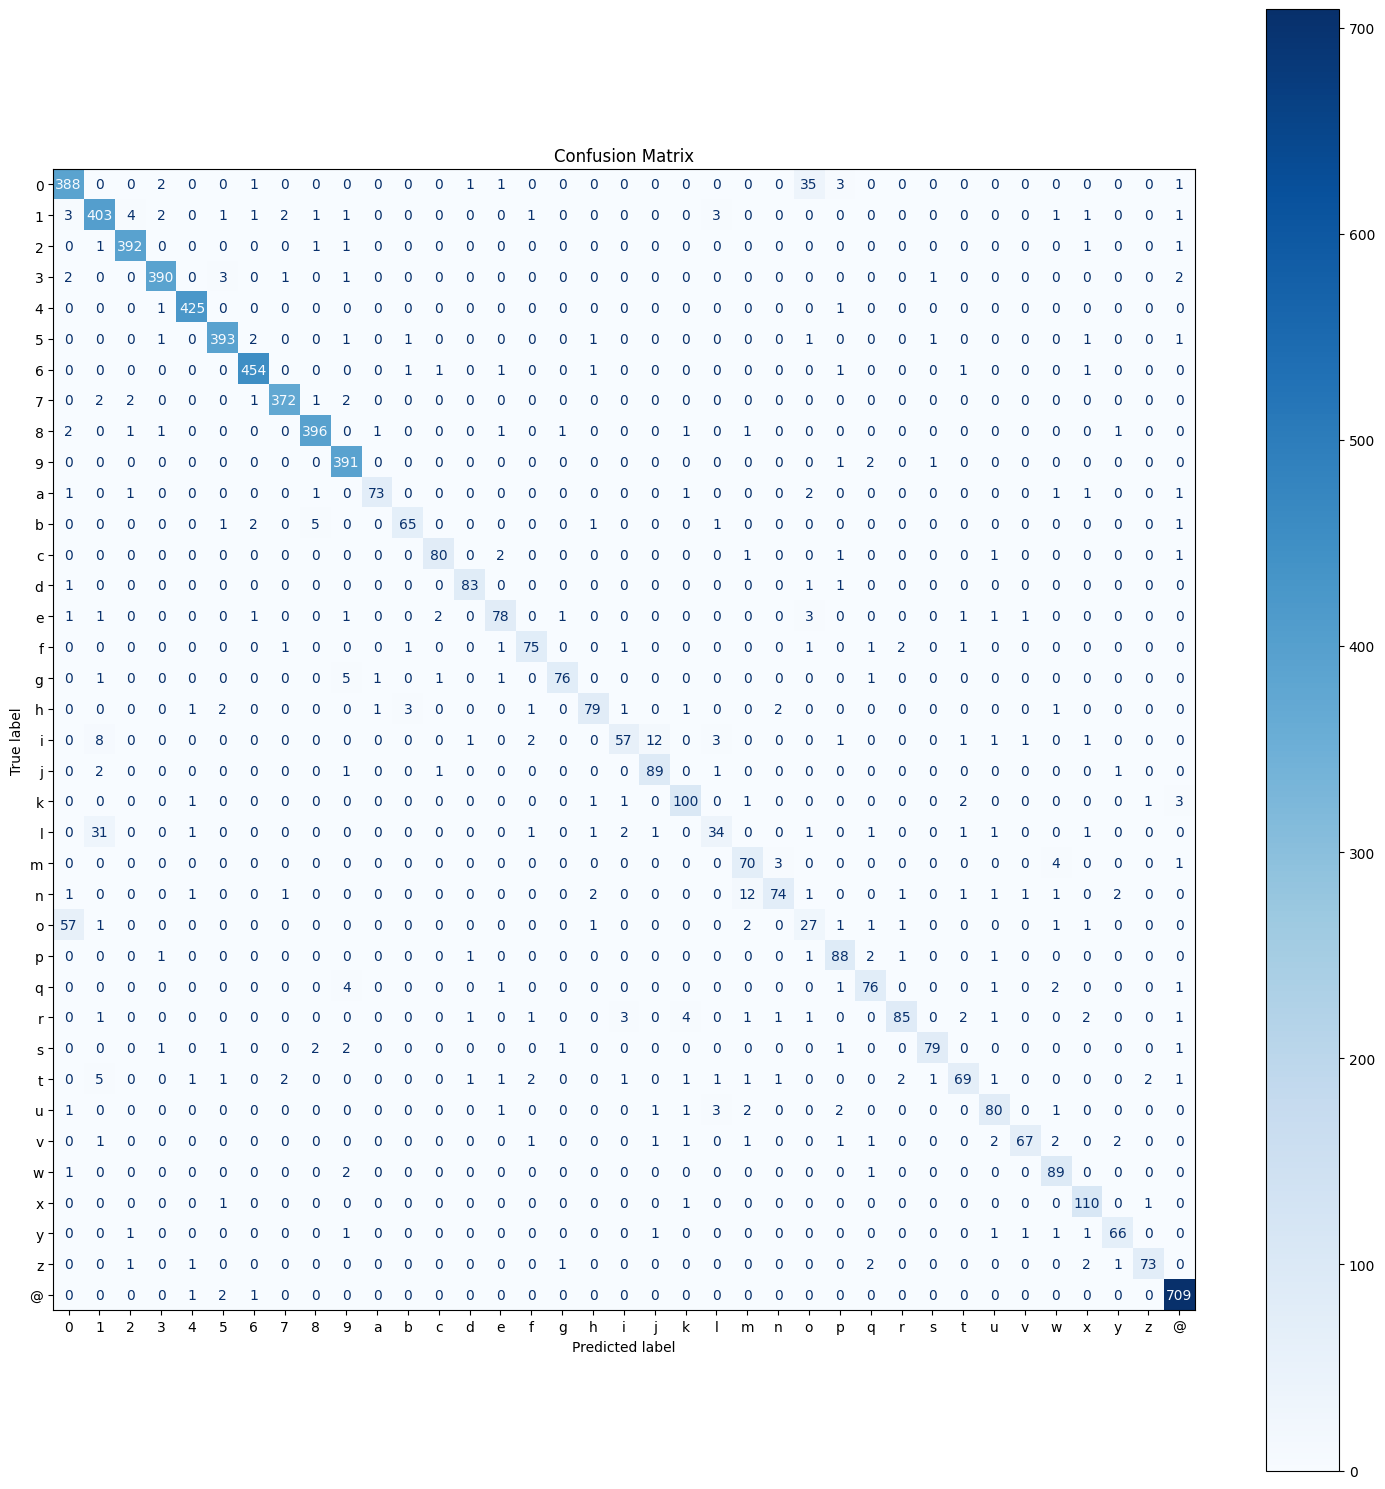

Accuracy test: 0.7332402234636871


In [ ]:
model.load_state_dict(torch.load("best_model_soft.pth"))
y_true, y_pred = get_predictions(model, soft_test_loader, device)
soft_confusion_matrix = generate_confusion_matrix(y_true, y_pred)
acc,_ = evaluate(model, soft_test_loader,loss_fn,device)
print(f"Accuracy test: {acc}")

In [ ]:
soft_results = get_metrics(soft_confusion_matrix)
data = {'Precision': soft_results['precision'],
        'Recall': soft_results['recall'],
        'F1_score': soft_results['f1_score'],
        }

df_results = pd.DataFrame(data, index = list(alphabet))
display(df_results)
print("accuracy = ", soft_results['accuracy'])

,Precision,Recall,F1_score
0,0.847162,0.898148,0.871910
1,0.881838,0.948235,0.913832
2,0.975124,0.987406,0.981227
3,0.977444,0.975000,0.976220
4,0.983796,0.995316,0.989523
5,0.970370,0.975186,0.972772
6,0.980562,0.984816,0.982684
7,0.981530,0.978947,0.980237
8,0.972973,0.975369,0.974170
9,0.946731,0.989873,0.967822


accuracy =  0.9294692737430168


##Augmented Soft Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CAPTCHA_CNN(max_length * alphabet_length).to(device)
loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

hist_train, hist_val = train_evaluate(
    model=model,
    dataloader_train=soft_train_loader_augmented,
    dataloader_val=soft_val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=200,
    name_file="best_model_augmented_soft.pth",
    scheduler=scheduler,
    early_stop_patience=25
)


Epoch 1/200
Model saved with validation accuracy: 0.0000
Train Loss: 0.1300, Train Acc: 0.0000
Val Loss: 0.1206, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 2/200
Train Loss: 0.1101, Train Acc: 0.0000
Val Loss: 0.1066, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 3/200
Train Loss: 0.1039, Train Acc: 0.0001
Val Loss: 0.1110, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 4/200
Train Loss: 0.0974, Train Acc: 0.0011
Val Loss: 0.1005, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 5/200
Model saved with validation accuracy: 0.0283
Train Loss: 0.0885, Train Acc: 0.0047
Val Loss: 0.0781, Val Acc: 0.0283, Best Val Acc: 0.0283

Epoch 6/200
Model saved with validation accuracy: 0.0535
Train Loss: 0.0785, Train Acc: 0.0226
Val Loss: 0.0705, Val Acc: 0.0535, Best Val Acc: 0.0535

Epoch 7/200
Train Loss: 0.0695, Train Acc: 0.0549
Val Loss: 0.1037, Val Acc: 0.0031, Best Val Acc: 0.0535

Epoch 8/200
Train Loss: 0.0620, Train Acc: 0.0985
Val Loss: 0.0783, Val Acc: 0.0503, Best Val Acc: 0.0535

Epoch 9/

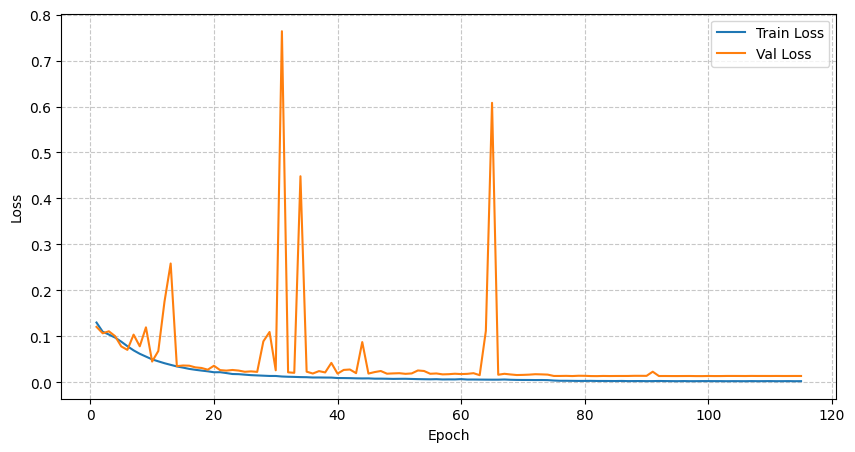

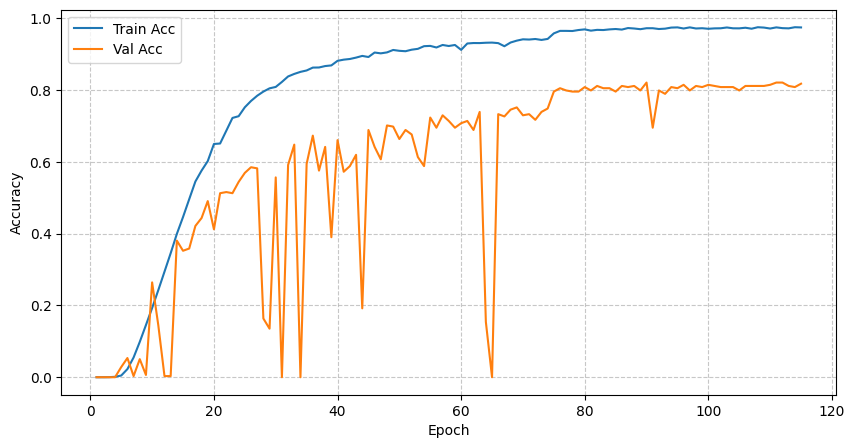

In [ ]:
plot_training_metrics(hist_train, hist_val)

##Augmented Soft Evaluation

<ipython-input-23-98ad9e9e353f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_augmented_soft.pth'))


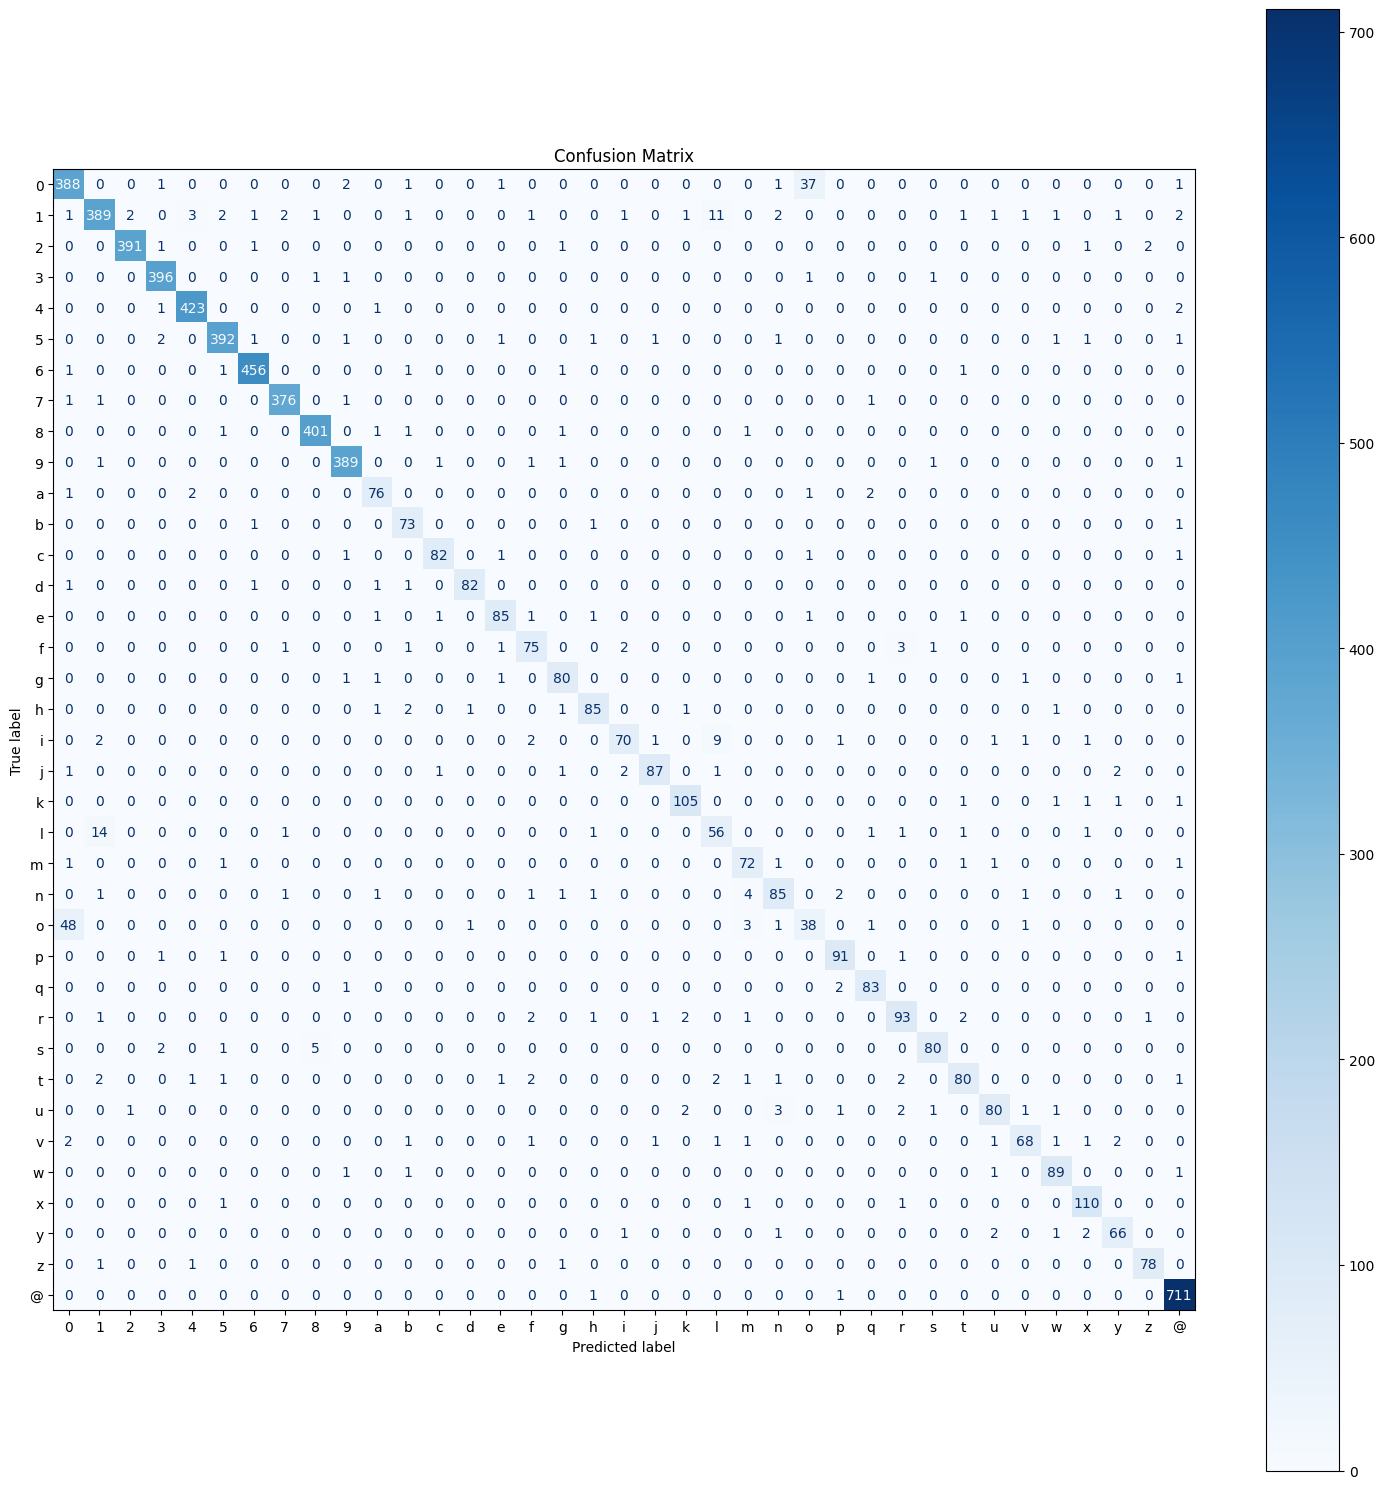

In [ ]:
model.load_state_dict(torch.load('best_model_augmented_soft.pth'))
y_true, y_pred = get_predictions(model, soft_test_loader, device)
soft_confusion_matrix = generate_confusion_matrix(y_true, y_pred)

In [ ]:
soft_results = get_metrics(soft_confusion_matrix)

In [ ]:
data = {'Precision': soft_results['precision'],
        'Recall': soft_results['recall'],
        'F1_score': soft_results['f1_score'],
}

df_results = pd.DataFrame(data, index = list(alphabet))
display(df_results)
print("accuracy = ", soft_results['accuracy'])

,Precision,Recall,F1_score
0,0.871910,0.898148,0.884835
1,0.944175,0.915294,0.929510
2,0.992386,0.984887,0.988622
3,0.980198,0.990000,0.985075
4,0.983721,0.990632,0.987165
5,0.977556,0.972705,0.975124
6,0.989154,0.989154,0.989154
7,0.986877,0.989474,0.988173
8,0.982843,0.987685,0.985258
9,0.977387,0.984810,0.981084


accuracy =  0.9470670391061452


## Hard Dataset Setup

Here we set up the "Hard" dataset in the same way we previously set up the "Soft" dataset

In [ ]:
hard_train_dir = "./CAPTCHA_dataset/hard/train"
hard_test_dir = "./CAPTCHA_dataset/hard/test"

hard_train_image_paths, hard_train_labels = load_image_paths_and_labels(hard_train_dir)
hard_test_image_paths, hard_test_labels = load_image_paths_and_labels(hard_test_dir)

train_size = int(0.95 * len(hard_train_image_paths))
val_size = len(hard_train_image_paths) - train_size

indices = torch.randperm(len(hard_train_image_paths)).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

hard_train_image_paths_split = [hard_train_image_paths[i] for i in train_indices]
hard_val_image_paths_split = [hard_train_image_paths[i] for i in val_indices]

hard_train_labels_split = [hard_train_labels[i] for i in train_indices]
hard_val_labels_split = [hard_train_labels[i] for i in val_indices]


hard_train_dataset_split = CaptchaDataset(
    hard_train_image_paths_split,
    train_transform=train_transform
)

hard_val_dataset_split = CaptchaDataset(
    hard_val_image_paths_split,
    train_transform=test_transform
)


hard_train_dataset_augmented_o_four_l = CaptchaDataset(
    file_paths=hard_train_image_paths_split,
    train_transform=train_transform,
    test_transform=test_transform,
    augment_0_transform=augment_0_transform,
    augment_4_letters_transform=augment_4_letters_transform,
    augment_o_l_transform=augment_o_l_transform,
    augment_0_ratio=2,
    augment_4_letters_ratio=3,
    augment_o_l_ratio=2,
)

hard_test_dataset = CaptchaDataset(
    hard_test_image_paths,
    test_transform=test_transform
)


hard_train_loader = DataLoader(hard_train_dataset_split, batch_size=64, shuffle=True)
hard_train_loader_augmented = DataLoader(hard_train_dataset_augmented_o_four_l, batch_size=64, shuffle=True)
hard_val_loader = DataLoader(hard_val_dataset_split, batch_size=1, shuffle= True)
hard_test_loader = DataLoader(hard_test_dataset, batch_size=1, shuffle=False)



## Hard Normal training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CAPTCHA_CNN(max_length * alphabet_length).to(device)
loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

hist_train, hist_val = train_evaluate(
    model=model,
    dataloader_train=hard_train_loader,
    dataloader_val=hard_val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=200,
    name_file="best_model_hard.pth",
    scheduler=scheduler,
    early_stop_patience=25
)


Epoch 1/200
Model saved with validation accuracy: 0.0000
Train Loss: 0.1499, Train Acc: 0.0002
Val Loss: 0.1111, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 2/200
Train Loss: 0.1114, Train Acc: 0.0000
Val Loss: 0.1098, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 3/200
Train Loss: 0.1091, Train Acc: 0.0000
Val Loss: 0.1119, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 4/200
Train Loss: 0.1079, Train Acc: 0.0000
Val Loss: 0.1202, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 5/200
Train Loss: 0.1033, Train Acc: 0.0002
Val Loss: 0.1339, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 6/200
Train Loss: 0.0985, Train Acc: 0.0004
Val Loss: 0.1346, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 7/200
Train Loss: 0.0945, Train Acc: 0.0011
Val Loss: 0.0969, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 8/200
Model saved with validation accuracy: 0.0177
Train Loss: 0.0895, Train Acc: 0.0022
Val Loss: 0.0899, Val Acc: 0.0177, Best Val Acc: 0.0177

Epoch 9/200
Train Loss: 0.0837, Train Acc: 0.0084
Val

In [ ]:
plot_training_metrics(hist_train, hist_val)

##Hard Normal Evaluation

In [53]:
model.load_state_dict(torch.load('best_model_hard.pth'))

<ipython-input-53-53270172f6ac>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_hard.pth'))


<All keys matched successfully>

In [54]:
acc, _ = evaluate(model, hard_test_loader, loss_fn, device)
print(acc)

0.7718073970690859


In [55]:
y_true, y_pred = get_predictions(model, hard_test_loader, device)

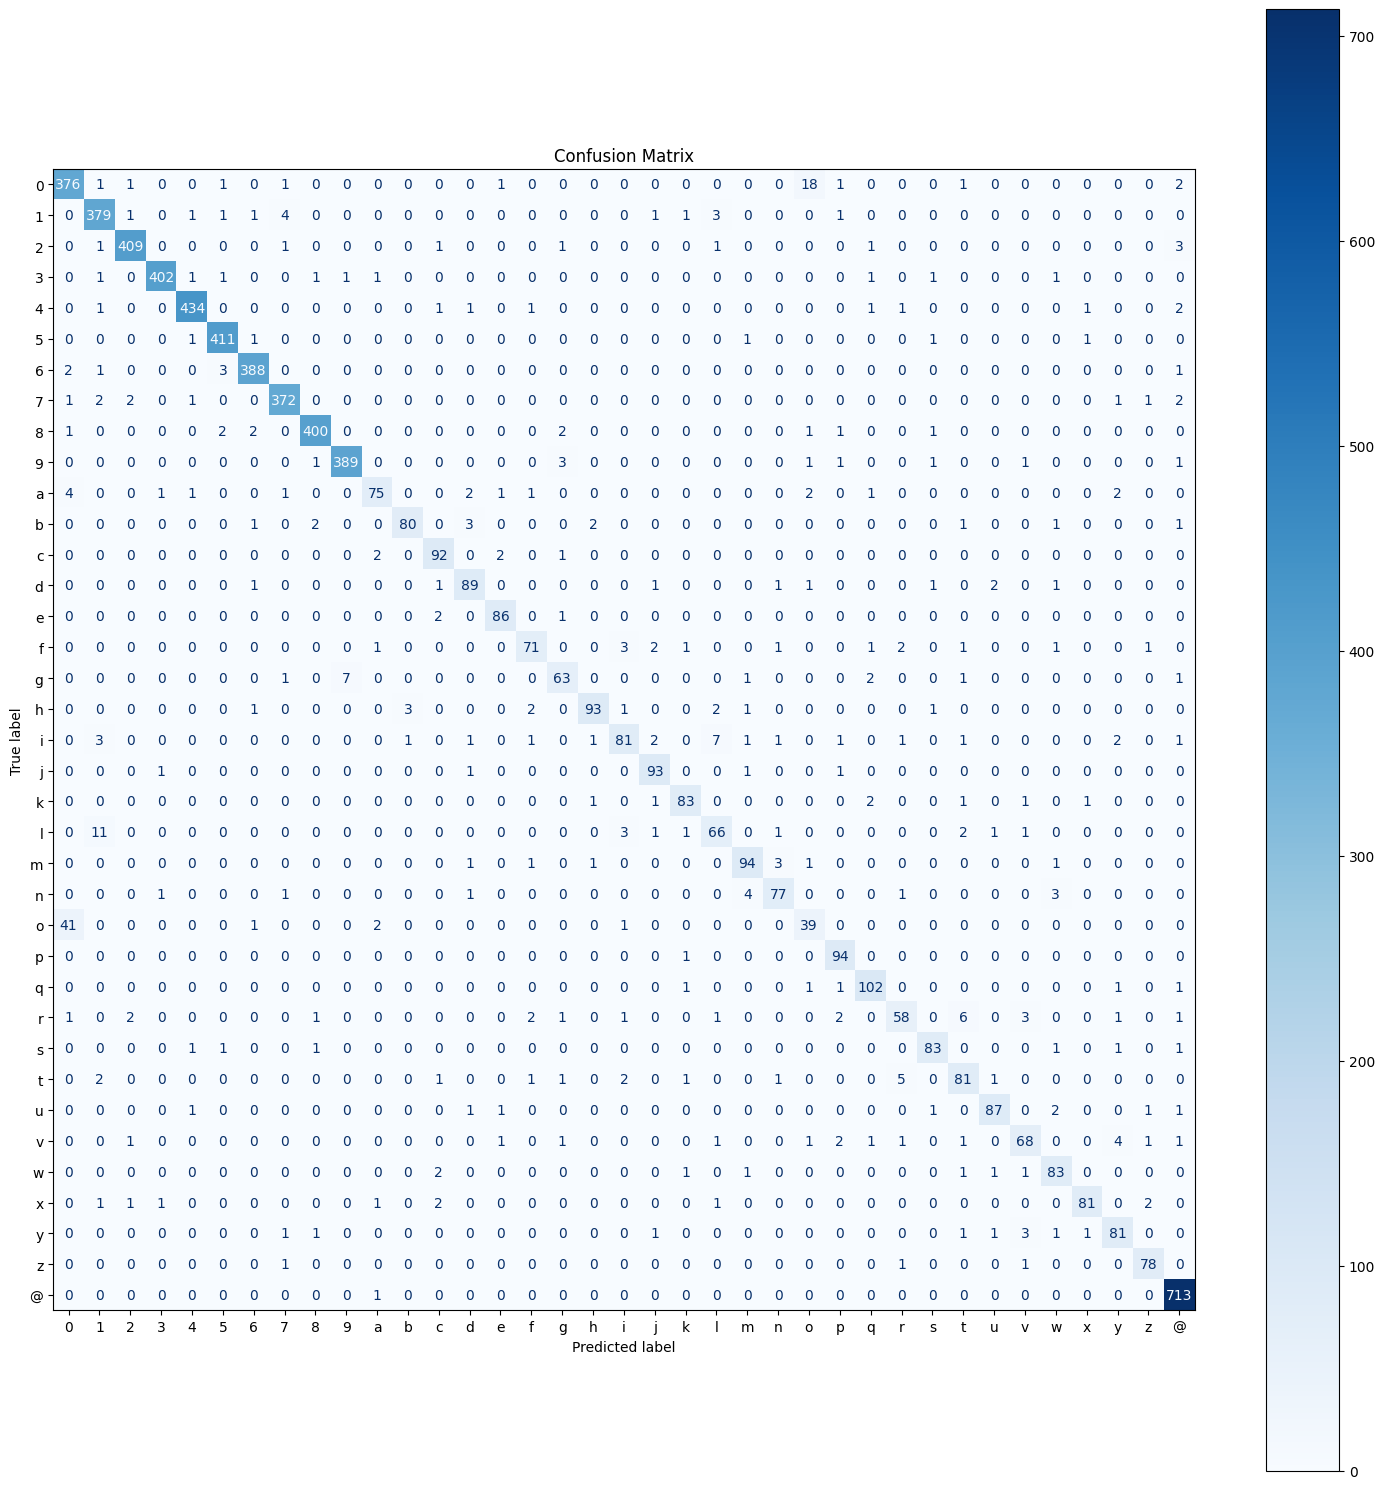

In [56]:
hard_confusion_matrix = generate_confusion_matrix(y_true, y_pred)

In [57]:
hard_results = get_metrics(hard_confusion_matrix)

In [58]:
data = {'Precision': hard_results['precision'],
        'Recall': hard_results['recall'],
        'F1_score': hard_results['f1_score'],
}

df_results = pd.DataFrame(data, index = list(alphabet))
display(df_results)
print("accuracy = ", hard_results['accuracy'])

,Precision,Recall,F1_score
0,0.882629,0.933002,0.907117
1,0.940447,0.964377,0.952261
2,0.980815,0.978469,0.979641
3,0.990148,0.978102,0.984088
4,0.984127,0.979684,0.981900
5,0.978571,0.987981,0.983254
6,0.979798,0.982278,0.981037
7,0.971279,0.973822,0.972549
8,0.982801,0.975610,0.979192
9,0.979849,0.977387,0.978616


accuracy =  0.9422191207257502


##Augmented Hard Training

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CAPTCHA_CNN(max_length * alphabet_length).to(device)
loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

hist_train, hist_val = train_evaluate(
    model=model,
    dataloader_train=hard_train_loader_augmented,
    dataloader_val=hard_val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=100,
    name_file="best_model_hard_augmented.pth",
    scheduler=scheduler,
    early_stop_patience=25
)


Epoch 1/100
Model saved with validation accuracy: 0.0000
Train Loss: 0.1324, Train Acc: 0.0000
Val Loss: 0.1265, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 2/100
Train Loss: 0.1088, Train Acc: 0.0000
Val Loss: 0.1176, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 3/100
Train Loss: 0.1035, Train Acc: 0.0001
Val Loss: 0.0988, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 4/100
Train Loss: 0.0977, Train Acc: 0.0005
Val Loss: 0.0896, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 5/100
Model saved with validation accuracy: 0.0035
Train Loss: 0.0899, Train Acc: 0.0045
Val Loss: 0.0848, Val Acc: 0.0035, Best Val Acc: 0.0035

Epoch 6/100
Model saved with validation accuracy: 0.0212
Train Loss: 0.0810, Train Acc: 0.0171
Val Loss: 0.0774, Val Acc: 0.0212, Best Val Acc: 0.0212

Epoch 7/100
Model saved with validation accuracy: 0.0707
Train Loss: 0.0729, Train Acc: 0.0459
Val Loss: 0.0653, Val Acc: 0.0707, Best Val Acc: 0.0707

Epoch 8/100
Model saved with validation accuracy: 0.0954
Train Loss: 0

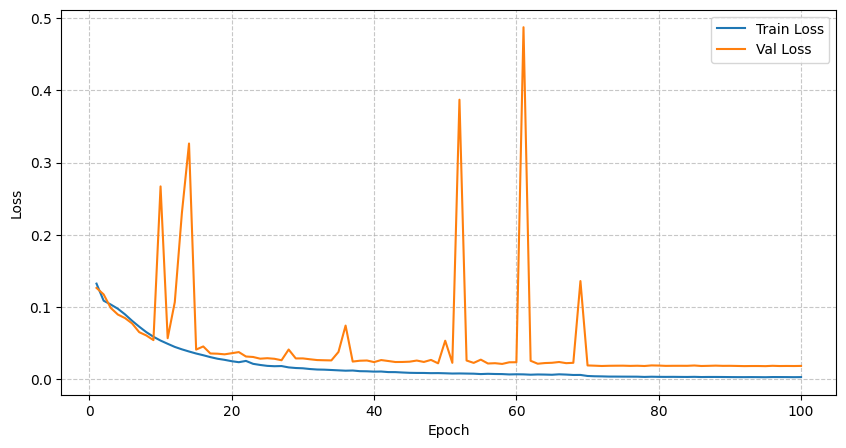

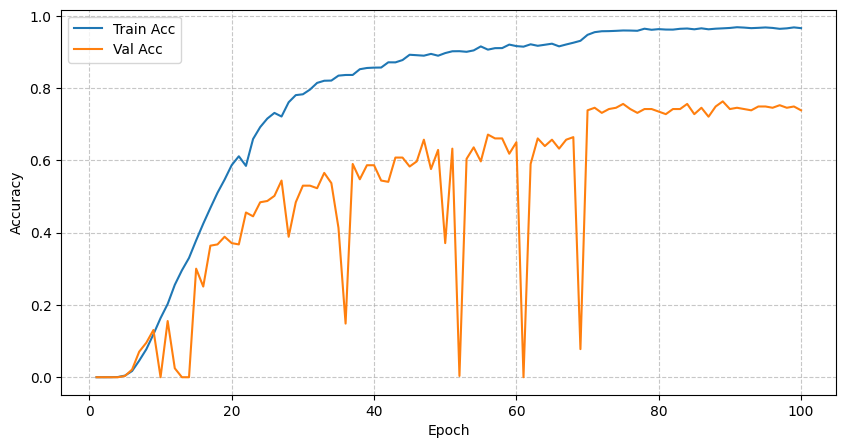

In [60]:
plot_training_metrics(hist_train, hist_val)

##Augmented Hard Evaluation

In [61]:
model.load_state_dict(torch.load('best_model_hard_augmented.pth'))

<ipython-input-61-12a37a80f089>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_hard_augmented.pth'))


<All keys matched successfully>

In [62]:
acc, _ = evaluate(model, hard_test_loader, loss_fn, device)
print(acc)

0.7173761339846476


In [63]:
y_true, y_pred = get_predictions(model, hard_test_loader, device)

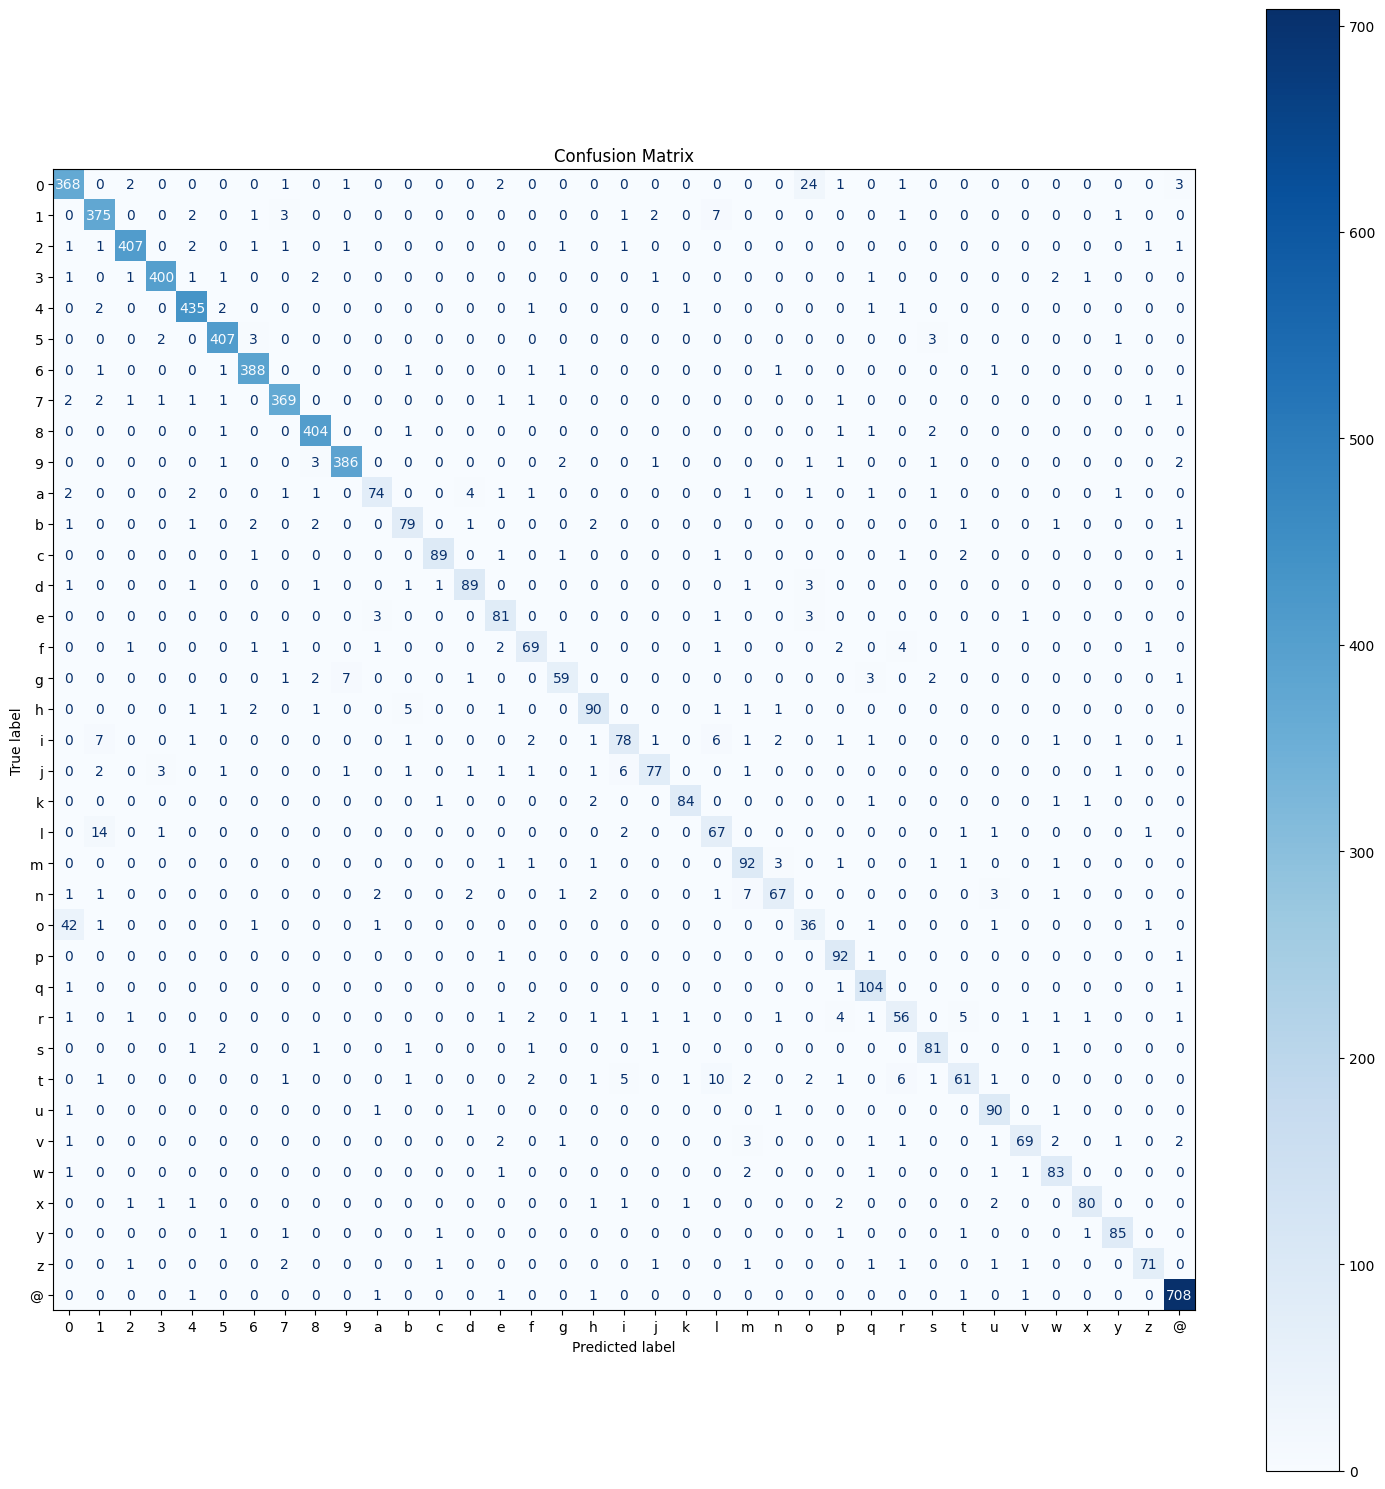

In [64]:
hard_confusion_matrix = generate_confusion_matrix(y_true, y_pred)

In [ ]:
hard_results = get_metrics(hard_confusion_matrix)

In [65]:
data = {'Precision': hard_results['precision'],
        'Recall': hard_results['recall'],
        'F1_score': hard_results['f1_score'],
}

df_results = pd.DataFrame(data, index = list(alphabet))
display(df_results)
print("accuracy = ", hard_results['accuracy'])

,Precision,Recall,F1_score
0,0.882629,0.933002,0.907117
1,0.940447,0.964377,0.952261
2,0.980815,0.978469,0.979641
3,0.990148,0.978102,0.984088
4,0.984127,0.979684,0.981900
5,0.978571,0.987981,0.983254
6,0.979798,0.982278,0.981037
7,0.971279,0.973822,0.972549
8,0.982801,0.975610,0.979192
9,0.979849,0.977387,0.978616


accuracy =  0.9422191207257502


#Combined Approach
In this section we aim to combine the "Soft" and the "Hard" training sets in order to train a more robust model that will be then tested on a combination of the "Soft" training set and the "Hard" training set.

##Combined Dataset Setup

In [66]:
combined_train_dataset = ConcatDataset([soft_train_dataset_split,
                                        hard_train_dataset_split])
combined_train_dataset_augmented = ConcatDataset([soft_train_dataset_augmented_o_four_l,
                                                  hard_train_dataset_augmented_o_four_l])

combined_val_dataset = ConcatDataset([soft_val_dataset_split, hard_val_dataset_split])

combined_test_dataset = ConcatDataset([soft_test_dataset, hard_test_dataset])

combined_train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)
combined_train_loader_augmented = DataLoader(combined_train_dataset_augmented, batch_size=64, shuffle=True)
combined_val_loader = DataLoader(combined_val_dataset, batch_size=1, shuffle=True)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=1, shuffle=False)


## Combined Normal Training

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CAPTCHA_CNN(max_length * alphabet_length).to(device)
loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

hist_train, hist_val = train_evaluate(
    model=model,
    dataloader_train=combined_train_loader,
    dataloader_val=combined_val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=100,
    name_file="best_model_combined.pth",
    scheduler=scheduler,
    early_stop_patience=25
)


Epoch 1/100
Model saved with validation accuracy: 0.0000
Train Loss: 0.1301, Train Acc: 0.0000
Val Loss: 0.1124, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 2/100
Train Loss: 0.1091, Train Acc: 0.0000
Val Loss: 0.1081, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 3/100
Train Loss: 0.1019, Train Acc: 0.0002
Val Loss: 0.1008, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 4/100
Model saved with validation accuracy: 0.0050
Train Loss: 0.0918, Train Acc: 0.0019
Val Loss: 0.0852, Val Acc: 0.0050, Best Val Acc: 0.0050

Epoch 5/100
Train Loss: 0.0809, Train Acc: 0.0126
Val Loss: 0.1811, Val Acc: 0.0000, Best Val Acc: 0.0050

Epoch 6/100
Train Loss: 0.0706, Train Acc: 0.0476
Val Loss: 0.2253, Val Acc: 0.0000, Best Val Acc: 0.0050

Epoch 7/100
Train Loss: 0.0623, Train Acc: 0.1026
Val Loss: 0.2067, Val Acc: 0.0017, Best Val Acc: 0.0050

Epoch 8/100
Model saved with validation accuracy: 0.1814
Train Loss: 0.0556, Train Acc: 0.1569
Val Loss: 0.0531, Val Acc: 0.1814, Best Val Acc: 0.1814

Epoch 9/

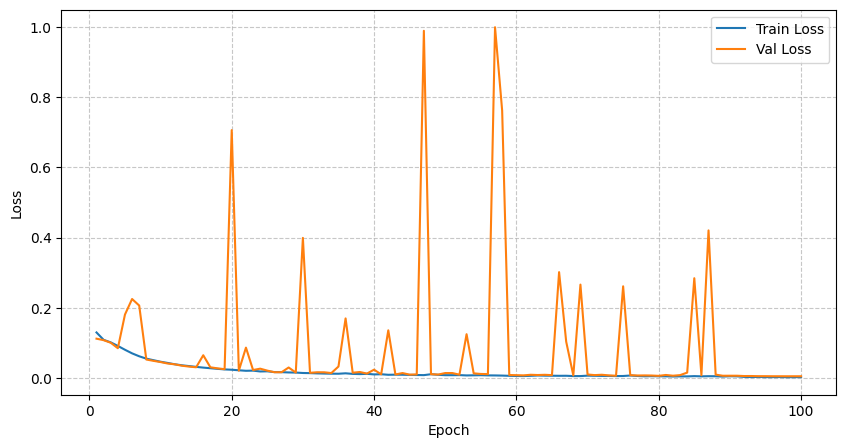

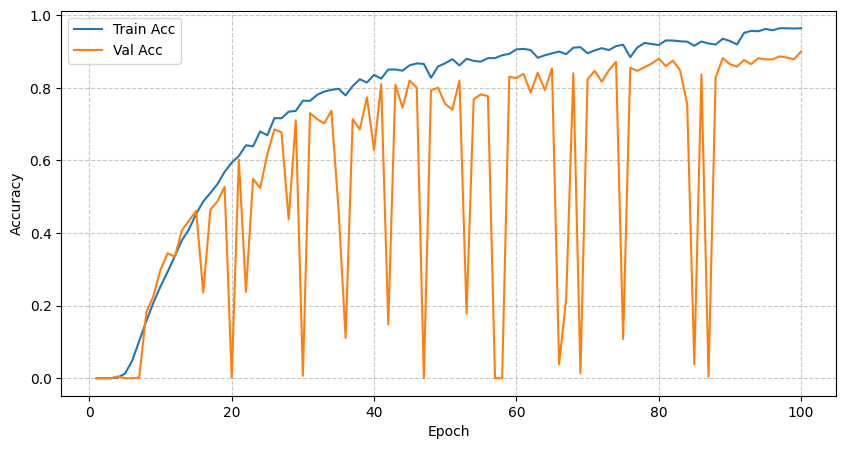

In [68]:
plot_training_metrics(hist_train, hist_val)

## Combined Normal Evaluation

In [69]:
model.load_state_dict(torch.load('best_model_combined.pth'))

<ipython-input-69-d2398cab8c10>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_combined.pth'))


<All keys matched successfully>

In [70]:
acc, _ = evaluate(model, combined_test_loader, loss_fn, device)
print(acc)

0.8907504363001745


In [71]:
y_true, y_pred = get_predictions(model, combined_test_loader, device)

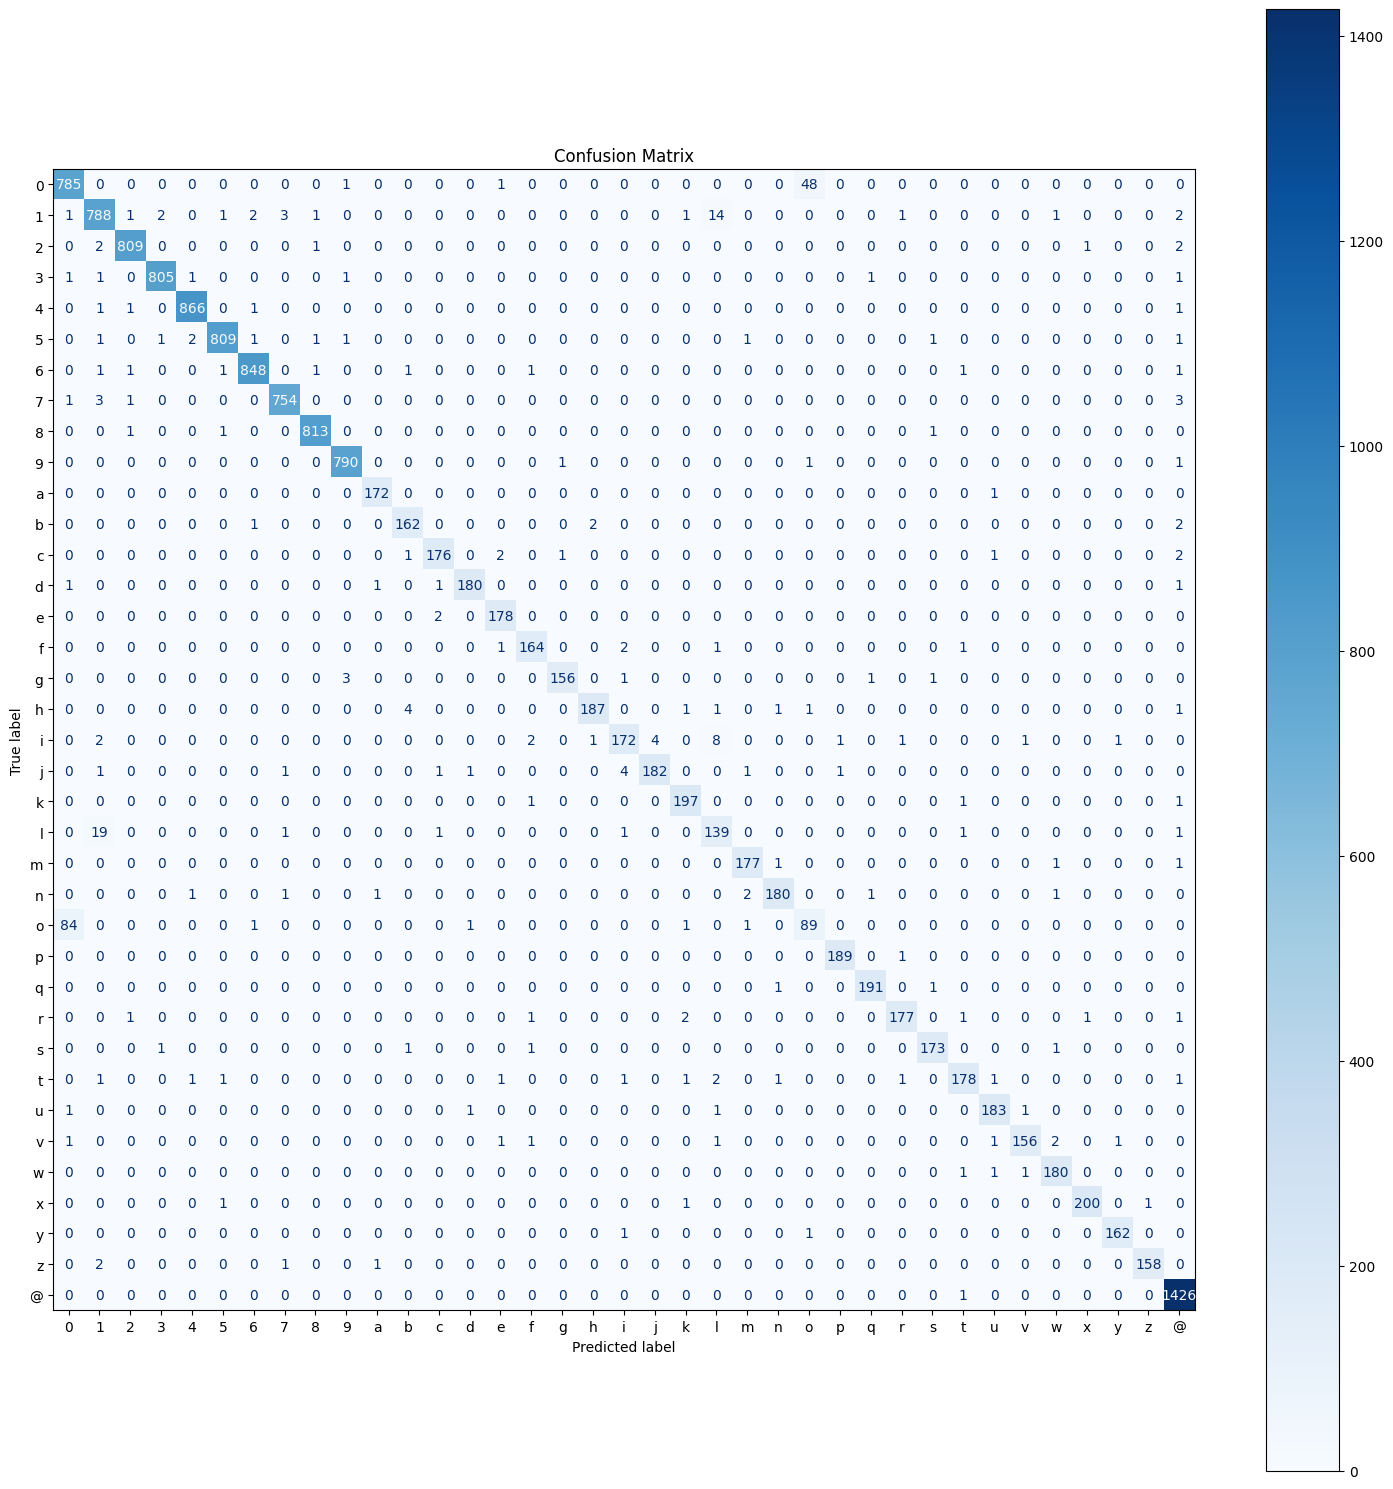

In [72]:
combined_confusion_matrix = generate_confusion_matrix(y_true, y_pred)

In [73]:
combined_results = get_metrics(combined_confusion_matrix)

In [74]:
data = {'Precision': combined_results['precision'],
        'Recall': combined_results['recall'],
        'F1_score': combined_results['f1_score'],
}

df_results = pd.DataFrame(data, index = list(alphabet))
display(df_results)
print("accuracy = ", combined_results['accuracy'])

,Precision,Recall,F1_score
0,0.897143,0.940120,0.918129
1,0.958637,0.963325,0.960976
2,0.992638,0.992638,0.992638
3,0.995056,0.992602,0.993827
4,0.994259,0.995402,0.994831
5,0.993857,0.987790,0.990814
6,0.992974,0.990654,0.991813
7,0.990802,0.989501,0.990151
8,0.995104,0.996324,0.995713
9,0.992462,0.996217,0.994336


accuracy =  0.9738917975567191


##Combined Augmented Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CAPTCHA_CNN(max_length * alphabet_length).to(device)
loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

hist_train, hist_val = train_evaluate(
    model=model,
    dataloader_train=combined_train_loader_augmented,
    dataloader_val=combined_val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=100,
    name_file="best_model_combined_augmented.pth",
    scheduler=scheduler,
    early_stop_patience=25
)


Epoch 1/200
Model saved with validation accuracy: 0.0000
Train Loss: 0.1196, Train Acc: 0.0000
Val Loss: 0.1015, Val Acc: 0.0000, Best Val Acc: 0.0000

Epoch 2/200
Model saved with validation accuracy: 0.0017
Train Loss: 0.1007, Train Acc: 0.0001
Val Loss: 0.0894, Val Acc: 0.0017, Best Val Acc: 0.0017

Epoch 3/200
Model saved with validation accuracy: 0.0433
Train Loss: 0.0856, Train Acc: 0.0114
Val Loss: 0.0696, Val Acc: 0.0433, Best Val Acc: 0.0433

Epoch 4/200
Model saved with validation accuracy: 0.1265
Train Loss: 0.0695, Train Acc: 0.0631
Val Loss: 0.0563, Val Acc: 0.1265, Best Val Acc: 0.1265

Epoch 5/200
Model saved with validation accuracy: 0.2030
Train Loss: 0.0579, Train Acc: 0.1372
Val Loss: 0.0474, Val Acc: 0.2030, Best Val Acc: 0.2030

Epoch 6/200
Train Loss: 0.0491, Train Acc: 0.2087
Val Loss: 0.1231, Val Acc: 0.0300, Best Val Acc: 0.2030

Epoch 7/200
Model saved with validation accuracy: 0.3877
Train Loss: 0.0435, Train Acc: 0.2789
Val Loss: 0.0344, Val Acc: 0.3877, Be

In [ ]:
plot_training_metrics(hist_train, hist_val)

## Combined Augmented Evaluation

In [ ]:
model.load_state_dict(torch.load('best_model_combined_augmented.pth'))

In [ ]:
acc, _ = evaluate(model, combined_test_loader, loss_fn, device)
print(acc)

In [ ]:
y_true, y_pred = get_predictions(model, combined_test_loader, device)

In [ ]:
combined_confusion_matrix = generate_confusion_matrix(y_true, y_pred)

In [ ]:
combined_results = get_metrics(combined_confusion_matrix)

In [ ]:
data = {'Precision': combined_results['precision'],
        'Recall': combined_results['recall'],
        'F1_score': combined_results['f1_score'],
}

df_results = pd.DataFrame(data, index = list(alphabet))
display(df_results)
print("accuracy = ", combined_results['accuracy'])

###Disclaimer
Due to a technical issue with colab and timing constraints we didn't train all models for the same amount of epochs. Hopefully we'll manage to do so before the presentation so that we can provide more relevant results.

## Results Analysis
### Soft Dataset

Training the model for 100 epochs on the Soft dataset without any sort of augmentation and testing it on the Soft test set resulted in the following scores:

* Average Precision: 0.8964
* Average Recall: 0.8761
* Average F1 Score:0.8835
* Accuracy:  0.9295

After the data augmentation and training the model for more than 100 epochs the results were the following:

* Average Precision: 0.9183
* Average Recall: 0.9152
* Average F1 Score:0.9163
* Accuracy: 0.9470

This improvement can be attributed to the better detection of the letter "o" that was previously being detected as 0 much more frequently. This can be observe watching the Precision, Recall and F1_Score that went respectively from  from  `0.364865	0.290323	0.323353` to `0.481013	0.408602	0.441860`.

Training the model for 200 epochs on the Hard dataset without augmentation and testing it on the Hard test set resulted in the following scores:

* Average Precision: 0.9095
* Average Recall: 0.9008
* Average F1 Score:0.9043
* Accuracy: 0.9422

After performing data augmentation and training the model for 100 epochs the results are inconclusive and require further investigation.

When training the model on the Soft and Hard dataset combined and testing it on a combination of the hard and soft test sets we noticed major improvements. In this scenario the scores after only 100 epochs were the following:

* Average Precision: 0.9642
* Average Recall: 0.9587
* Average F1 Score:0.9612
* Accuracy:  0.9738

The biggest improvement can be seen on the detection of the letter "o" which now has Precision, Recall and F1_Scores of `0.635714 	0.502825 	0.561514`.

The results that could be obtained performing data augmentation before training this combined model are not currently available in this notebook due to the aforementioned technical and timing issues.

## Conclusions

What emerges from the Result analysis is that the "Achille's heel" of our model is the detection of the letter "o". This issue is caused by two main factors.

The first one is datasets imbalance. As shown in the characters distribution histogram the number 0 is much more frequent than the letter "o". Because of this the models tend to misclassify the letter. We tried to tackle this issue applying data augmentation techniques in order to balance the dataset. This improved the results in the "soft" dataset.

The second factor is the actual similarity between the letter "o" and the number 0, especially in a CAPTCHA scenario where letters and numbers are distorted.

The same can be said about the letter "l" and the number 1, even though for this combination of characters we got better results.

Another limitation of our model is the fact that it only works on CAPTCHAs with 4 or 5 alphanumeric characters and.